# Import Library

In [ ]:
# Install library transformers
!pip install transformers

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# Unduh dan Load Dataset

In [ ]:
# Install kaggle
!pip install kaggle

In [ ]:
# type your Kaggle API token here
token = {"username":"","key":""}

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'dwiknrd/reviewuniversalstudio'

Dataset URL: https://www.kaggle.com/datasets/dwiknrd/reviewuniversalstudio
License(s): CC0-1.0
 88% 11.0M/12.6M [00:00<00:00, 113MB/s]
100% 12.6M/12.6M [00:00<00:00, 120MB/s]


In [ ]:
# Mengekstraksi file .zip
import zipfile

dataset_zip = zipfile.ZipFile('reviewuniversalstudio.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

In [ ]:
!ls

kaggle.json  reviewuniversalstudio.zip	sample_data  universal_studio_branches.csv


# Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv('universal_studio_branches.csv')
df

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida
...,...,...,...,...,...,...
50899,vinz20,4.0,"March 29, 2010",I'll Be Back Only If ...,This is my first visit to a Universal Studio t...,Universal Studios Singapore
50900,betty l,4.0,"March 29, 2010",Universal Studios Singapore Experience,We finally visited Singapore's very first them...,Universal Studios Singapore
50901,spoonos65,4.0,"March 28, 2010",Impressive but not quite finished!,We visited during the first week of its 'soft ...,Universal Studios Singapore
50902,HeatSeekerWrexham_UK,4.0,"March 22, 2010",Small but beautifully marked,We visited on the 3rd day of the 'soft' openin...,Universal Studios Singapore


In [ ]:
# Informasi data sebelum pelabelan
# Melihat tipe data setiap kolom
print(df.info())

# Melihat data kolom
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50904 entries, 0 to 50903
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   reviewer      50904 non-null  object 
 1   rating        50904 non-null  float64
 2   written_date  50904 non-null  object 
 3   title         50904 non-null  object 
 4   review_text   50904 non-null  object 
 5   branch        50904 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.3+ MB
None
Index(['reviewer', 'rating', 'written_date', 'title', 'review_text', 'branch'], dtype='object')


**Proses Pelabelan**

In [ ]:
import pandas as pd
from textblob import TextBlob

# Fungsi untuk menentukan final_label
def determine_final_label(rating, text):
    # Label awal berdasarkan rating
    if rating <= 2:
        return "Negatif"
    elif rating == 3:
        return "Netral"
    elif rating > 3:  # Rating 4-5
        # Analisis sentimen pada review_text
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity
        if polarity > 0.1:  # Threshold positif
            return "Positif"
        elif polarity < -0.1:  # Threshold negatif
            return "Negatif"
        else:
            return "Netral"

# Menambahkan kolom final_label
df['label'] = df.apply(lambda row: determine_final_label(row['rating'], row['review_text']), axis=1)

# Menampilkan hasil
df[['rating', 'review_text', 'label']]

,rating,review_text,label
0,2.0,We went to Universal over Memorial Day weekend...,Negatif
1,1.0,The food service is horrible. I’m not reviewin...,Negatif
2,2.0,I booked this vacation mainly to ride Hagrid m...,Negatif
3,4.0,When a person tries the test seat for the ride...,Netral
4,5.0,"Ok, I can't stress enough to anyone and everyo...",Positif
...,...,...,...
50899,4.0,This is my first visit to a Universal Studio t...,Netral
50900,4.0,We finally visited Singapore's very first them...,Netral
50901,4.0,We visited during the first week of its 'soft ...,Netral
50902,4.0,We visited on the 3rd day of the 'soft' openin...,Positif


In [ ]:
# Informasi data setelah pelabelan
# Melihat tipe data setiap kolom
print(df.info())

# Melihat data kolom
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50904 entries, 0 to 50903
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   reviewer      50904 non-null  object 
 1   rating        50904 non-null  float64
 2   written_date  50904 non-null  object 
 3   title         50904 non-null  object 
 4   review_text   50904 non-null  object 
 5   branch        50904 non-null  object 
 6   label         50904 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.7+ MB
None
Index(['reviewer', 'rating', 'written_date', 'title', 'review_text', 'branch',
       'label'],
      dtype='object')


In [ ]:
# Menampilkan statistik deskriptif
print("Statistik deskriptif dari train dataset:")
display(df.describe())

Statistik deskriptif dari train dataset:


,rating
count,50904.000000
mean,4.256994
std,1.046716
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
# Mengecek jumlah nilai null pada setiap kolom
print("Jumlah nilai null per kolom:")
df.isnull().sum()

Jumlah nilai null per kolom:


,0
reviewer,0
rating,0
written_date,0
title,0
review_text,0
branch,0
label,0


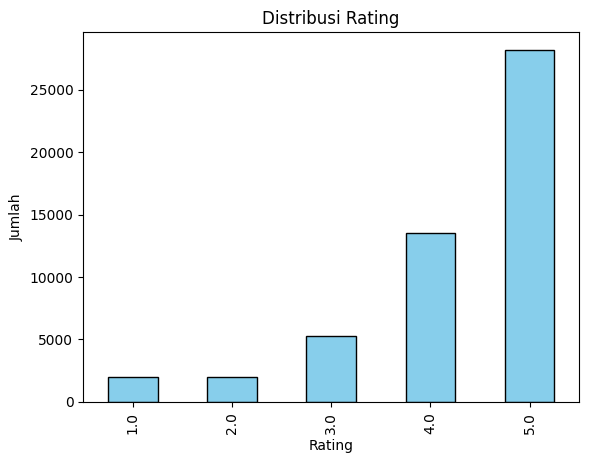

In [ ]:
# Visualisasi Distribusi Rating
df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

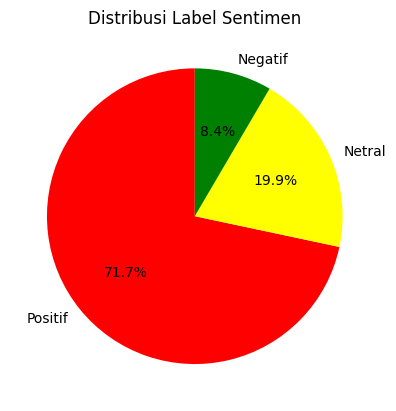

In [ ]:
# Visualisasi Distribusi Label Sentimen
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['red', 'yellow', 'green'], startangle=90)
plt.title('Distribusi Label Sentimen')
plt.ylabel('')
plt.show()

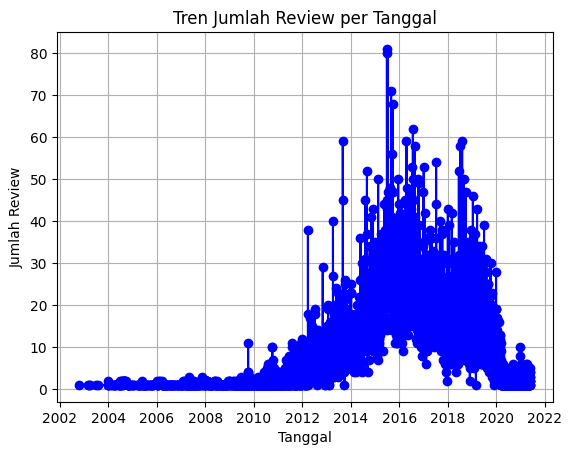

In [ ]:
# Visualisasi Jumlah Review per Tanggal
df['written_date'] = pd.to_datetime(df['written_date'])  # Konversi ke datetime
df_by_date = df.groupby(df['written_date'].dt.date).size()

df_by_date.plot(kind='line', marker='o', color='blue')
plt.title('Tren Jumlah Review per Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Review')
plt.grid()
plt.show()

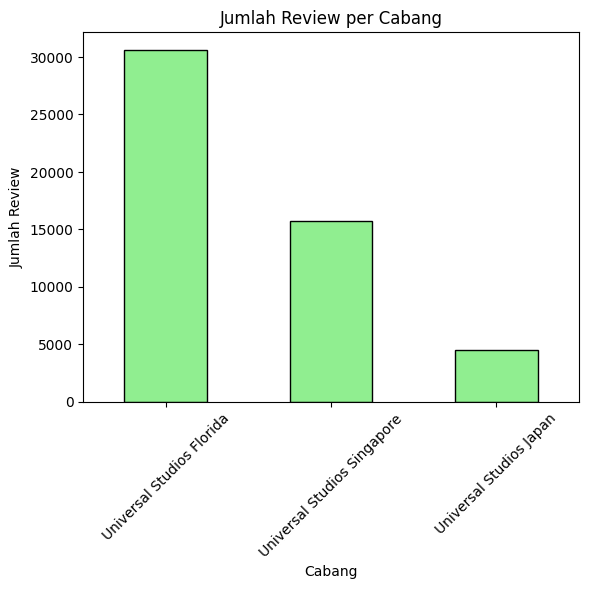

In [ ]:
# Visualisasi Jumlah Review per Lokasi Cabang (Branch)
df['branch'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Jumlah Review per Cabang')
plt.xlabel('Cabang')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=45)
plt.show()

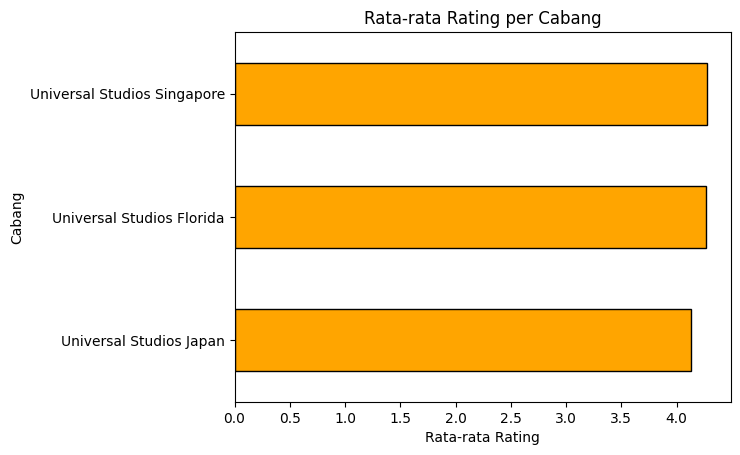

In [ ]:
# Visualisasi Rata-rata Rating Per Cabang
df.groupby('branch')['rating'].mean().sort_values().plot(kind='barh', color='orange', edgecolor='black')
plt.title('Rata-rata Rating per Cabang')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Cabang')
plt.show()

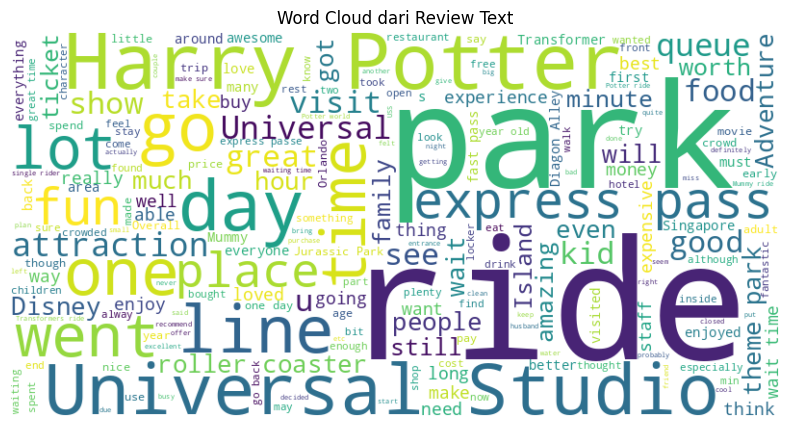

In [ ]:
# WordCloud untuk Review Text
from wordcloud import WordCloud

text = " ".join(review for review in df['review_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Review Text')
plt.show()

# Preprocessing Data

In [ ]:
import re

def clean_data(text):
    # Konversi ke lowercase
    text = text.lower()
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Menghapus mention @username
    text = re.sub(r'@\w+', '', text)
    # Menghapus hashtag #hashtag (tetap menyimpan kata setelah '#')
    text = re.sub(r'#(\w+)', r'\1', text)
    # Menghapus simbol umum (kecuali spasi)
    text = re.sub(r'[^\w\s]', '', text)
    # Menghapus emotikon
    text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)
    text = re.sub(r'[\U0001F300-\U0001F5FF]', '', text)
    text = re.sub(r'[\U0001F680-\U0001F6FF]', '', text)
    text = re.sub(r'[\U0001F700-\U0001F7FF]', '', text)
    # Menghapus angka
    text = re.sub(r'\w*\d\w*', '', text).strip()
    # Menghapus karakter non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Menghapus spasi ekstra
    text = ' '.join(text.split())
    return text

# Terapkan fungsi clean_data pada kolom 'review_text'
df['review_text'] = df['review_text'].apply(clean_data)

# Menampilkan hasil setelah pembersihan
df['review_text']

,review_text
0,we went to universal over memorial day weekend...
1,the food service is horrible im not reviewing ...
2,i booked this vacation mainly to ride hagrid m...
3,when a person tries the test seat for the ride...
4,ok i cant stress enough to anyone and everyone...
...,...
50899,this is my first visit to a universal studio t...
50900,we finally visited singapores very first theme...
50901,we visited during the first week of its soft o...
50902,we visited on the day of the soft opening tick...


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return tokens

df['tokenized_text'] = df['review_text'].apply(tokenize_text)
df[['review_text', 'tokenized_text']]

,review_text,tokenized_text
0,we went to universal over memorial day weekend...,"[went, universal, memorial, day, weekend, tota..."
1,the food service is horrible im not reviewing ...,"[food, service, horrible, im, reviewing, food,..."
2,i booked this vacation mainly to ride hagrid m...,"[booked, vacation, mainly, ride, hagrid, motor..."
3,when a person tries the test seat for the ride...,"[person, tries, test, seat, rides, gets, green..."
4,ok i cant stress enough to anyone and everyone...,"[ok, cant, stress, enough, anyone, everyone, g..."
...,...,...
50899,this is my first visit to a universal studio t...,"[first, visit, universal, studio, theme, park,..."
50900,we finally visited singapores very first theme...,"[finally, visited, singapores, first, theme, p..."
50901,we visited during the first week of its soft o...,"[visited, first, week, soft, opening, unfortun..."
50902,we visited on the day of the soft opening tick...,"[visited, day, soft, opening, ticket, sales, l..."


In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk

# Unduh resource yang diperlukan
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Terapkan lemmatization pada kolom 'tokenized_tweet'
df['lemmatized_text'] = df['tokenized_text'].apply(lemmatize_tokens)

# Menampilkan hasil akhir
df[['review_text', 'tokenized_text', 'lemmatized_text']]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,review_text,tokenized_text,lemmatized_text
0,we went to universal over memorial day weekend...,"[went, universal, memorial, day, weekend, tota...","[went, universal, memorial, day, weekend, tota..."
1,the food service is horrible im not reviewing ...,"[food, service, horrible, im, reviewing, food,...","[food, service, horrible, im, reviewing, food,..."
2,i booked this vacation mainly to ride hagrid m...,"[booked, vacation, mainly, ride, hagrid, motor...","[booked, vacation, mainly, ride, hagrid, motor..."
3,when a person tries the test seat for the ride...,"[person, tries, test, seat, rides, gets, green...","[person, try, test, seat, ride, get, green, li..."
4,ok i cant stress enough to anyone and everyone...,"[ok, cant, stress, enough, anyone, everyone, g...","[ok, cant, stress, enough, anyone, everyone, g..."
...,...,...,...
50899,this is my first visit to a universal studio t...,"[first, visit, universal, studio, theme, park,...","[first, visit, universal, studio, theme, park,..."
50900,we finally visited singapores very first theme...,"[finally, visited, singapores, first, theme, p...","[finally, visited, singapore, first, theme, pa..."
50901,we visited during the first week of its soft o...,"[visited, first, week, soft, opening, unfortun...","[visited, first, week, soft, opening, unfortun..."
50902,we visited on the day of the soft opening tick...,"[visited, day, soft, opening, ticket, sales, l...","[visited, day, soft, opening, ticket, sale, li..."


# Pemodelan LSTM (Long Short-Term Memory)

In [ ]:
# Membagi data menjadi set pelatihan dan pengujian
X = df['lemmatized_text']
y = df['label']

# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Membagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Ukuran data
print("Data latih:", X_train.shape, y_train.shape)
print("Data uji:", X_test.shape, y_test.shape)

Data latih: (40723,) (40723,)
Data uji: (10181,) (10181,)


In [ ]:
# Tokenisasi dan padding untuk model LSTM
max_length = 128  # Panjang maksimum input
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
# Model LSTM
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(256, return_sequences=True, recurrent_activation='sigmoid'), # Mengubah return_sequences menjadi False untuk mengubah Flatten
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train LSTM model
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7265 - loss: 0.6715 - val_accuracy: 0.7886 - val_loss: 0.4783
Epoch 2/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8208 - loss: 0.4379 - val_accuracy: 0.7919 - val_loss: 0.4716
Epoch 3/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8592 - loss: 0.3518 - val_accuracy: 0.7948 - val_loss: 0.4976
Epoch 4/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9103 - loss: 0.2434 - val_accuracy: 0.7630 - val_loss: 0.6297
Epoch 5/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9435 - loss: 0.1548 - val_accuracy: 0.7761 - val_loss: 0.7339
Epoch 6/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9688 - loss: 0.0922 - val_accuracy: 0.7777 - val_loss: 1.0478
Epoch 7/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9801 - loss: 0.0612 - val_accuracy: 0.7605 - val_loss: 1.2055
Epoch 8/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9838 - loss: 0.0493 - 

# Evaluasi Model

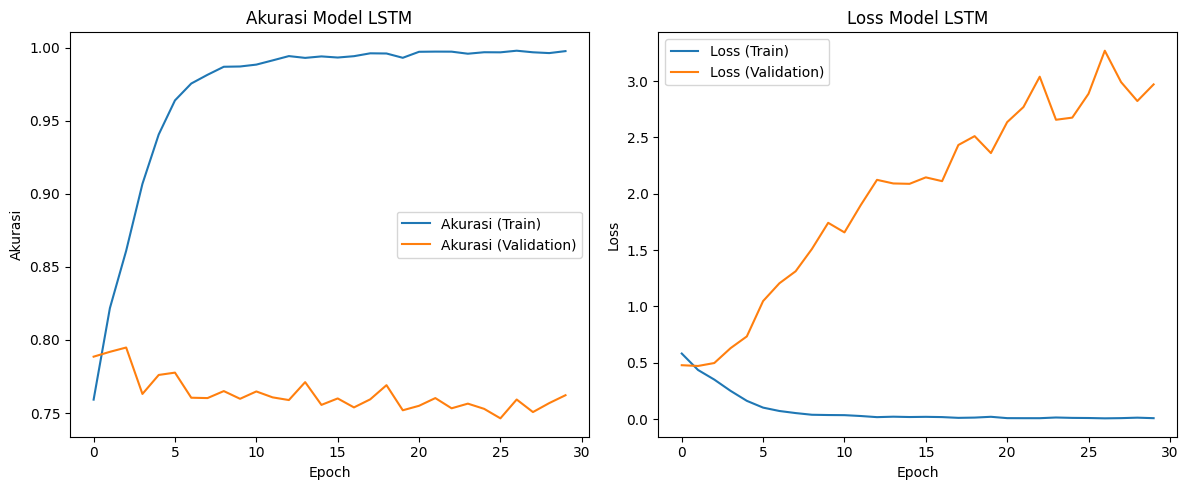

In [ ]:
# Grafik untuk LSTM
plt.figure(figsize=(12, 5))

# Akurasi LSTM
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Akurasi (Train)')
plt.plot(lstm_history.history['val_accuracy'], label='Akurasi (Validation)')
plt.title('Akurasi Model LSTM')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss LSTM
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Loss (Train)')
plt.plot(lstm_history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss Model LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluasi kedua model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'LSTM Test Accuracy: {lstm_accuracy:.4f}')
print(f'LSTM Test Loss: {lstm_loss:.4f}')

319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7645 - loss: 3.0304
LSTM Test Accuracy: 0.7580
LSTM Test Loss: 3.0804


In [ ]:
# Prediksi dengan model LSTM
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)

# Classification report untuk LSTM
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm_classes, target_names=label_encoder.classes_))

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

     Negatif       0.57      0.44      0.50       857
      Netral       0.44      0.39      0.42      2017
     Positif       0.85      0.90      0.87      7307

    accuracy                           0.76     10181
   macro avg       0.62      0.58      0.59     10181
weighted avg       0.74      0.76      0.75     10181



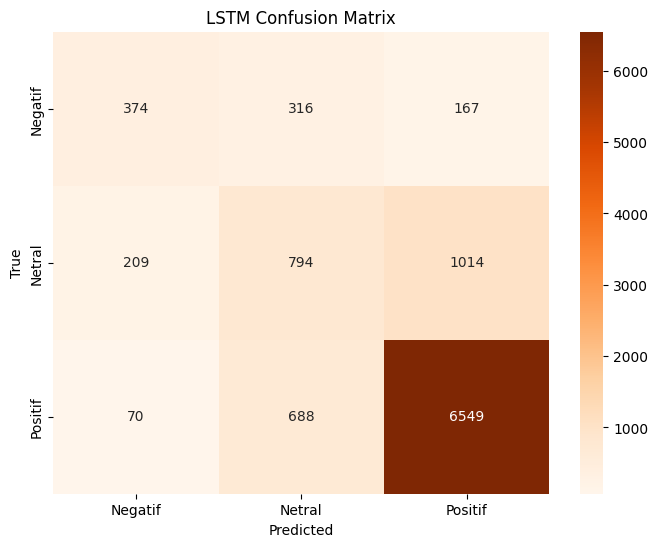

In [ ]:
# Confusion matrix untuk LSTM
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Oranges")
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save Model

In [ ]:
# Menyimpan model ke file .h5
lstm_model.save('/content/lstm_model.h5')

print("Model telah disimpan dalam format .h5")

import joblib

# Simpan scaler sebagai file .joblib
tokenizer_filename = '/content/tokenizer.joblib'
joblib.dump(tokenizer, tokenizer_filename)
print(f"Tokenizer model disimpan ke: {tokenizer_filename}")

Model telah disimpan dalam format .h5
Tokenizer model disimpan ke: /content/tokenizer.joblib


# Prediksi Model

In [ ]:
# Example new data for prediction
new_data = [
    "The experience at Universal Studios was amazing, and I enjoyed every moment.",  # Positif
    "The service was terrible and extremely disappointing.",  # Negatif
    "The attractions were interesting, but the staff's behavior was just average.",  # Netral
    "I loved the rides and the overall atmosphere of the park. Highly recommended!",  # Positif
    "The tickets are overpriced, and the waiting times were unbearable.",  # Negatif
    "The food was okay, but nothing extraordinary. Could have been better.",  # Netral
    "The staff was very friendly, and the place was clean and organized.",  # Positif
    "It was a complete waste of money. I would not recommend it to anyone.",  # Negatif
    "The fireworks show at the end of the day was breathtaking!",  # Positif
    "The park is very crowded, and it’s hard to enjoy the attractions.",  # Negatif
    "We had a lot of fun, and the kids absolutely loved it.",  # Positif
    "The bathrooms were dirty, and there was no soap available.",  # Negatif
    "The queue management was efficient, and the staff helped us a lot.",  # Positif
    "Some rides were closed, and there was no prior notification. Disappointing.",  # Negatif
    "The music played throughout the park was wonderful and set the mood perfectly.",  # Positif
]

# Proses tokenisasi pada data baru
new_data_seq = tokenizer.texts_to_sequences(new_data)

# Proses padding agar panjang sesuai dengan panjang maksimum (max_length)
new_data_pad = pad_sequences(new_data_seq, maxlen=max_length, padding='post')

# Melakukan prediksi
predictions = lstm_model.predict(new_data_pad)

# Mengubah hasil prediksi menjadi label kelas
predicted_labels = [label_encoder.classes_[np.argmax(pred)] for pred in predictions]

# Menampilkan hasil prediksi
for text, label in zip(new_data, predicted_labels):
    print(f"Teks: \"{text}\" -> Prediksi Label: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Teks: "The experience at Universal Studios was amazing, and I enjoyed every moment." -> Prediksi Label: Positif
Teks: "The service was terrible and extremely disappointing." -> Prediksi Label: Negatif
Teks: "The attractions were interesting, but the staff's behavior was just average." -> Prediksi Label: Netral
Teks: "I loved the rides and the overall atmosphere of the park. Highly recommended!" -> Prediksi Label: Positif
Teks: "The tickets are overpriced, and the waiting times were unbearable." -> Prediksi Label: Netral
Teks: "The food was okay, but nothing extraordinary. Could have been better." -> Prediksi Label: Netral
Teks: "The staff was very friendly, and the place was clean and organized." -> Prediksi Label: Positif
Teks: "It was a complete waste of money. I would not recommend it to anyone." -> Prediksi Label: Netral
Teks: "The fireworks show at the end of the day was breathtaking!" -> Prediksi Label: Positif
Teks: "The park is very crowded